Setup the plot, set the lower and upper bounds for the entire chart, or comment out the set_xlim to auto-scale. Also of inerest is the resolution which is the frequency increment for calculations. Also set the maximum harmonic to display. (should be odd for a square wave) 5th or 7th are probably good values for most cases.

basemag is the "zero" point for magnitudes. normalized values use 0. If using something like dBm or dB relative to RF then choose something a bit below the noise floor. (-180 can work pretty well)

<IPython.core.display.Javascript object>


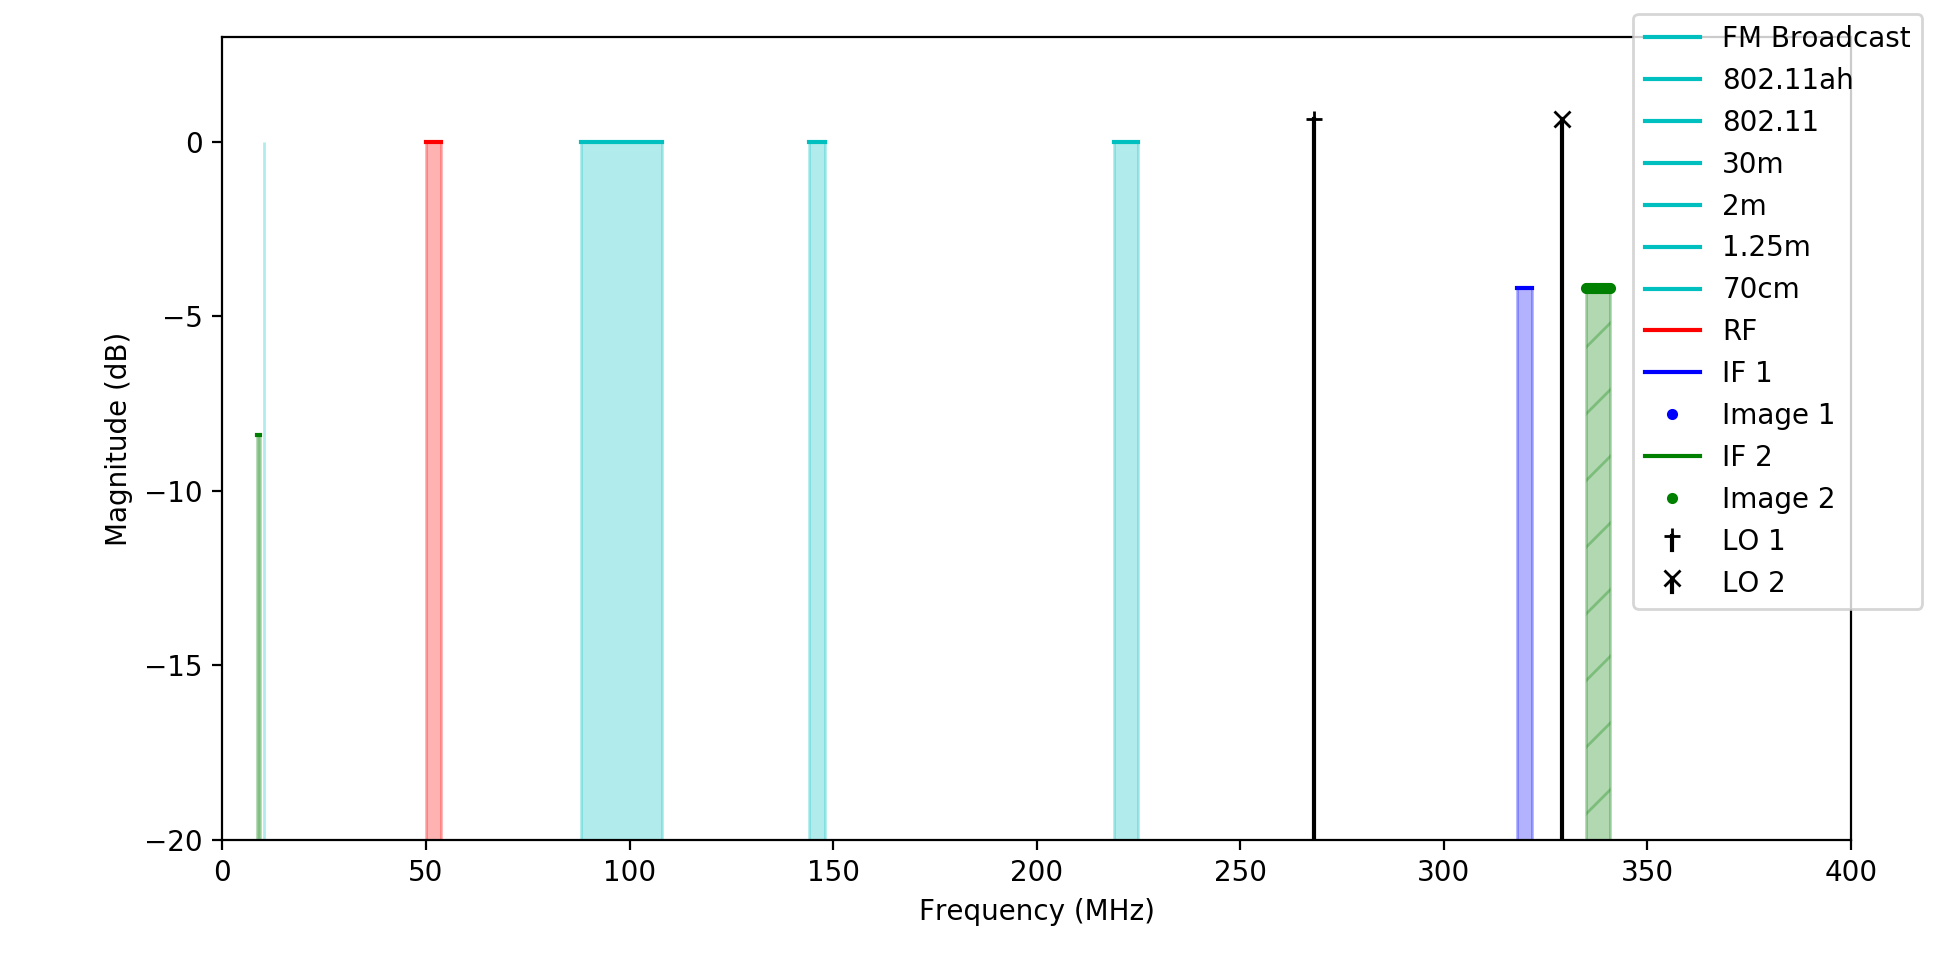

Text(0, 0.5, 'Magnitude (dB)')

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import plotly.tools

fig, ax = plt.subplots()

mag_unit = "dB"
freq_unit = "MHz"
basemag = -150
frequency_resolution = 0.25
max_harmonic = 9

ax.set_xlabel(f"Frequency ({freq_unit})")
ax.set_ylabel(f"Magnitude ({mag_unit})")

In [12]:
# just a quick way to adjust the bounds
lower_bound, upper_bound = 0, 400
ax.set_ylim(top=3, bottom=-20)
_=ax.set_xlim(left=lower_bound, right=upper_bound)

Set some important ranges to avoid. There are some useful ones below that can be uncommented as needed. Mostly active bands to avoid such as GPS, WiFi, etc.

In [3]:
bands_of_interest = {
    'FM Broadcast': (88, 108),
    #'AM Broadcast': (0.530, 1.700),
    '802.11ah': (902, 928),
    '802.11': (2401, 2495),
    #'802.11n': (4910, 5875),
    #'Microwave Oven': (2430, 2470),
    '30m': (10.1, 10.15),
    #'20m': (14., 14.350),
    #'17m': (18.068, 18.168),
    #'15m': (21., 21.450),
    #'12m': (24.890, 24.990),
    #'10m': (28.0, 29.7),
    #'6m': (50., 54.),
    '2m': (144., 148.),
    '1.25m': (219., 225.),
    '70cm': (430., 440.),
}

for nm, rng in bands_of_interest.items():
    mag = np.zeros(shape=(2,))
    ax.plot(rng, mag, 'c-', label=nm)
    ax.fill_between(rng, mag, y2=basemag, color='c', alpha=0.3)

Set the input RF frequency range and magnitude. Common magnitudes are 1.0 or normalize multiples or 0.0 for dB relative to RF. If you know absolute power, you can specify dBm but it's rarely useful for this tool.

In [4]:
rf_low, rf_high = 50., 54.
rf_bandwidth = rf_high - rf_low

rf_range = np.arange(rf_low, rf_high, frequency_resolution)
rf_mag = np.zeros(shape=rf_range.shape)
ax.plot(rf_range, rf_mag, "r-", label="RF")
_=ax.fill_between(rf_range, rf_mag, y2=basemag, color="r", alpha=0.3)

Next, specify the IFs. The LO will be calculated and harmonics will be plotted. By default, the harmonics will assume a perfect square wave LO but you can change this if you know the actual performance. If you're just looking for open frequencies, the default should be fine. If you're also designing filters, you might want to better approximate power so you know if you are attenuating enough.

We assume the "out" (RF or previous IF) is a sine wave so we don't calculate harmonics. This is only a possible issue with RF since these will already be calculated for a previous IF. The RF harmonics should also be near fully attenuated by the RF bandpass so it's pretty safe to ignore them for this simple tool.

Also need to calculate the image band and display that for help with filter design.

Sum and difference frequencies will have harmonics since the LO is a square wave. They won't be as close to a square as the LO in most cases but still treat them as such for worst case magnitudes. This completely ignores ever order harmonics in the sum/difference.

center, bandwidth and insertion_loss should be self explainatory.

prev_mag is the magnitude of the previous stage (RF or IF)

out_low, out_high, and out_bw are the frequency range for the in/out frequency (i.e. RF or previous IF) and the filter bandwidth for that ferquency

injection is IF.LOW_SIDE or IF.HIGH_SIDE

In [5]:
class IF:
    LOW_SIDE=-1
    HIGH_SIDE=1
    def __init__(self, if_num, center, bandwidth, injection, out_low, out_high, out_bw=None, insertion_loss=0., prev_mag=1.):
        self.if_num = if_num
        self.center = center
        out_hbw = out_bw / 2. if out_bw is not None else (out_high - out_low) / 2.
        self.low = self.center - out_hbw
        self.high = self.center + out_hbw
        self.if_mag = prev_mag - insertion_loss
        self.range = np.arange(self.low, self.high, frequency_resolution)
        self.mag = np.ones(shape=self.range.shape) * self.if_mag
        self.bandwidth = bandwidth
        
        # calculate the local oscillator. The injection parameter identifies this as the desired
        # LO frequency and not the image
        self.lo_injection = injection
        self.lo_low = np.abs(self.low + self.lo_injection * out_low)
        self.lo_high = np.abs(self.high + self.lo_injection * out_high)
        self.lo_center = (self.lo_low + self.lo_high) / 2.
        self.lo_mag = 1.
        
        self.image_low = self.lo_low + self.low
        self.image_high = self.lo_high + self.high
        self.image_range = np.arange(self.image_low, self.image_high, frequency_resolution)
        self.image_mag = np.ones(shape=self.image_range.shape) * prev_mag
        
        # calculate harmonics
        self.lo_harmonics = np.arange(1, max_harmonic + 1, 2) * self.lo_center
        self.lo_harmonic_mag = 2. / (np.pi * np.arange(1, max_harmonic + 1, 2)) * self.lo_mag

    def plot(self, ax, color, harmonic_symbol):
        ax.plot(self.range, self.mag, color+'-', label=f"IF {self.if_num}")
        ax.fill_between(self.range, self.mag, y2=basemag, color=color, alpha=0.3)
        ax.plot(self.image_range, self.image_mag, color+'.', label=f'Image {self.if_num}')
        ax.fill_between(self.image_range, self.image_mag, y2=basemag, color=color, alpha=0.3, hatch='/')
        ax.stem(self.lo_harmonics, self.lo_harmonic_mag, bottom=basemag,
                markerfmt=harmonic_symbol+'k', basefmt=' ', linefmt='-k', label=f"LO {self.if_num}")
    
    def __str__(self):
        return f"""IF {self.if_num} Frequency: {self.center} {freq_unit}
IF magnitude: {self.if_mag} {mag_unit}
Injection: {'Low' if self.lo_injection == IF.LOW_SIDE else 'High'} side
Local oscillator: {self.lo_center} {freq_unit} x {self.bandwidth} {freq_unit}
Image band: {self.image_low} {freq_unit}, {self.image_high} {freq_unit}
Harmonics: {self.lo_harmonics}"""

In [6]:
if1 = IF(if_num=1, center=320., bandwidth=1., injection=IF.LOW_SIDE, out_low=rf_low, out_high=rf_high, prev_mag=rf_mag[0], insertion_loss=4.2)
print(if1)
if1.plot(ax, 'b', '+')

IF 1 Frequency: 320.0 MHz
IF magnitude: -4.2 dB
Injection: Low side
Local oscillator: 268.0 MHz x 1.0 MHz
Image band: 586.0 MHz, 590.0 MHz
Harmonics: [ 268.  804. 1340. 1876. 2412.]


In [7]:
if2 = IF(if_num=2, center=9., bandwidth=0.027, injection=IF.HIGH_SIDE, out_low=if1.low, out_high=if1.high, out_bw=if1.bandwidth, prev_mag=if1.if_mag, insertion_loss=4.2)
print(if2)
if2.plot(ax, 'g', 'x')

IF 2 Frequency: 9.0 MHz
IF magnitude: -8.4 dB
Injection: High side
Local oscillator: 329.0 MHz x 0.027 MHz
Image band: 335.0 MHz, 341.0 MHz
Harmonics: [ 329.  987. 1645. 2303. 2961.]


<IPython.core.display.Javascript object>


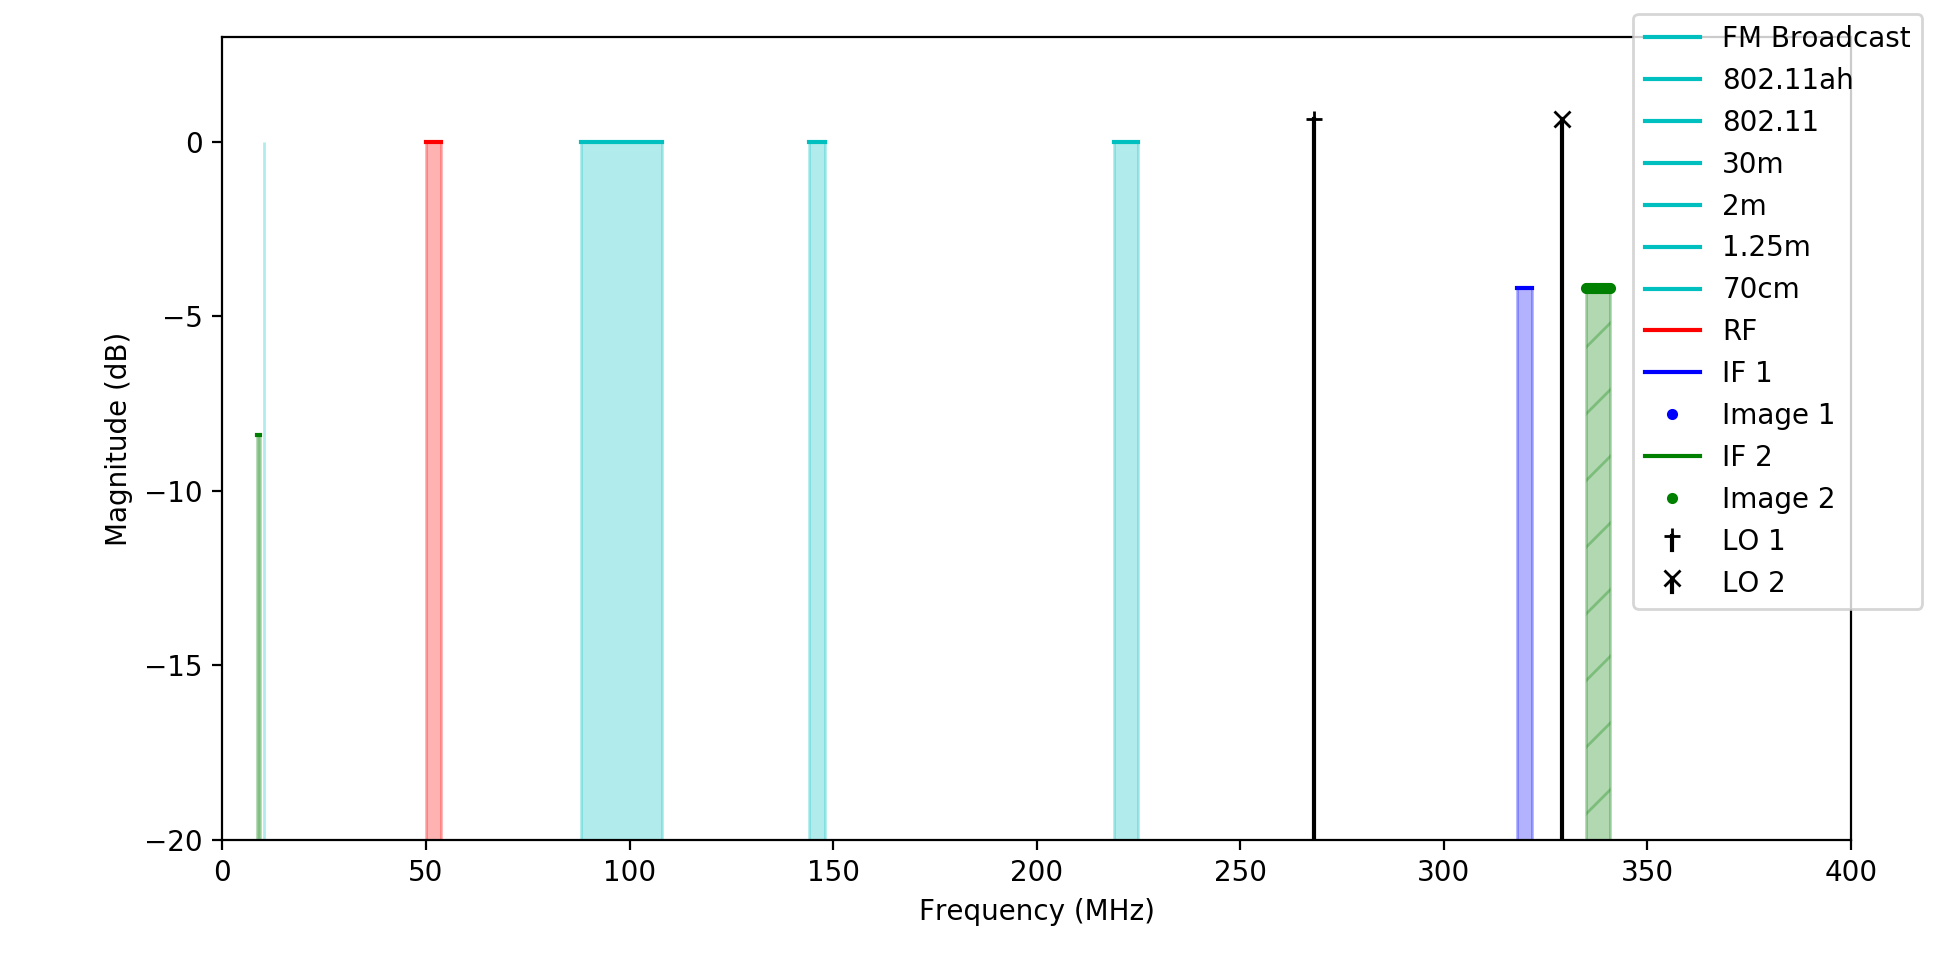

In [8]:
fig.tight_layout()
leg = fig.legend(loc='upper right')
leg.set_alpha(0.6)
fig